# Chapter 6

In [2]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd

## Selection/distortion effect

In [3]:
np.random.seed(2)
n = 200
p = 0.1
newsworthiness = np.random.normal(size=n)
trusthworthiness = np.random.normal(size=n)
score = newsworthiness + trusthworthiness

In [4]:
threshold = np.quantile(score,1-p)

In [5]:
selected = score >= threshold

In [6]:
np.corrcoef(newsworthiness[selected], trusthworthiness[selected])

array([[ 1.        , -0.73834648],
       [-0.73834648,  1.        ]])

Text(0, 0.5, 'trustworthiness')

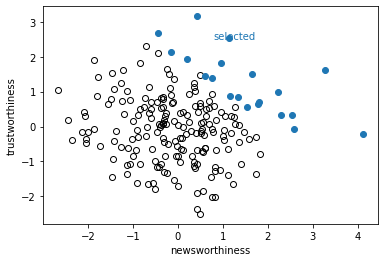

In [7]:
# Figure 6.1
plt.scatter(newsworthiness[~selected], trusthworthiness[~selected], lw=1, edgecolor="k", color=(0, 0, 0, 0))
plt.scatter(newsworthiness[selected], trusthworthiness[selected], color="C0")
plt.text(0.8, 2.5, "selected", color="C0")

plt.xlabel("newsworthiness")
plt.ylabel("trustworthiness")

# Multicolinearity

In [8]:
n = 100
height = np.random.normal(10,2, size=n)
leg_proportion = np.random.uniform(0.4, 0.5, size=n)
left_leg = leg_proportion * height + np.random.normal(0, 0.02, size=n)
right_leg = leg_proportion * height + np.random.normal(0, 0.02, size=n)
heights = pd.DataFrame({'height': height,
                        'left_leg':left_leg,
                        'right_leg':right_leg})


In [9]:
with pm.Model() as m1:
    alpha = pm.Normal('alpha', 10, 100)
    beta_left = pm.Normal('beta_left', 2, 10)
    beta_right = pm.Normal('beta_right', 2, 10)
    sigma = pm.Exponential('sigma', 1)
    
    mu = pm.Deterministic('mu', alpha + beta_left * heights['left_leg']+ beta_right * heights['right_leg'])
    sdr = pm.Normal('height', mu, sd=sigma, observed=heights['height'])
    m1_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_right, beta_left, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 155 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.


In [10]:
az.summary(m1_trace, var_names=['alpha','sigma', 'beta_left', 'beta_right'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.954,0.291,0.407,1.487,0.006,0.004,2177.0,1996.0,1.0
sigma,0.597,0.042,0.518,0.673,0.001,0.001,1890.0,1775.0,1.0
beta_left,3.756,2.138,-0.143,7.874,0.053,0.038,1599.0,1795.0,1.0
beta_right,-1.741,2.145,-5.735,2.298,0.054,0.038,1593.0,1793.0,1.0


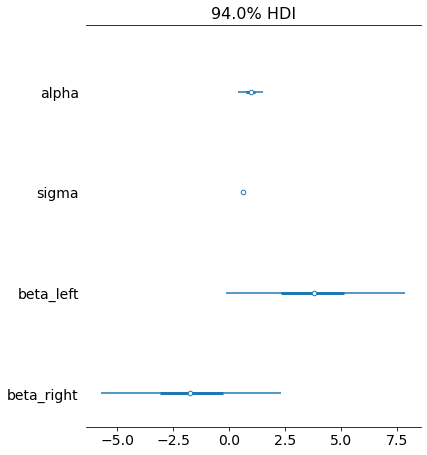

In [11]:
az.plot_forest(
    [
        m1_trace
    ],
    var_names=['alpha','sigma', 'beta_left', 'beta_right'],
    combined=True,
);

Text(0.5, 1.0, 'Joint Posterior distribution of beta_left and beta_right')

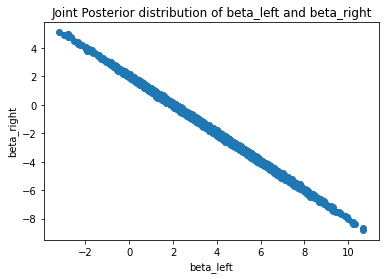

In [12]:
plt.scatter(m1_trace.posterior['beta_left'].values,m1_trace.posterior['beta_right'].values)
plt.xlabel('beta_left')
plt.ylabel('beta_right')
plt.title('Joint Posterior distribution of beta_left and beta_right')

Text(0.5, 1.0, 'Sum of beta_left and beta_right')

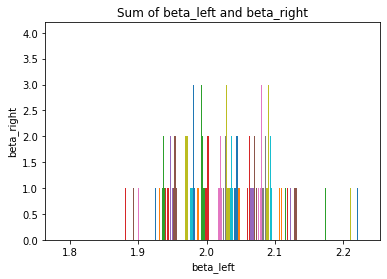

In [13]:
plt.hist(m1_trace.posterior['beta_left'].values+m1_trace.posterior['beta_right'].values)
plt.xlabel('beta_left')
plt.ylabel('beta_right')
plt.title('Sum of beta_left and beta_right')

# Multicollinear milk

In [17]:
milk = pd.read_csv('./data/milk.csv', sep=';')

In [18]:
milk.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [19]:
def standarize(col):
    return (col - np.mean(col))/np.std(col)

In [21]:
milk['standarized_kcal'] = standarize(milk["kcal.per.g"])

In [23]:
milk['standarized_fat'] = standarize(milk["perc.fat"])
milk['standarized_lactose'] = standarize(milk["perc.lactose"])

In [24]:
with pm.Model() as m1:
    alpha = pm.Normal('alpha', 0, 0.2)
    beta = pm.Normal('beta_fat', 0, 0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', alpha + beta * milk['standarized_fat'])
    sdr = pm.Normal('standarized_kcal', mu, sd=sigma, observed=milk['standarized_kcal'])
    m1_trace = pm.sample(return_inferencedata=True)
    m1_prior_predictive = pm.sample_prior_predictive()
    
with pm.Model() as m2:
    alpha = pm.Normal('alpha', 0, 0.2)
    beta = pm.Normal('beta_lactose', 0, 0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', alpha + beta * milk['standarized_lactose'])
    sdr = pm.Normal('standarized_kcal', mu, sd=sigma, observed=milk['standarized_kcal'])
    m2_trace = pm.sample(return_inferencedata=True)
    m2_prior_predictive = pm.sample_prior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_fat, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_lactose, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


In [31]:
az.summary(m1_trace, var_names=['beta_fat', 'alpha'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_fat,0.856,0.091,0.680,1.019,0.001,0.001,4229.0,2370.0,1.0
alpha,0.001,0.085,-0.155,0.154,0.001,0.001,3875.0,2751.0,1.0


In [32]:
az.summary(m2_trace, var_names=['beta_lactose', 'alpha'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_lactose,-0.899,0.078,-1.036,-0.748,0.001,0.001,4820.0,2943.0,1.0
alpha,-0.002,0.072,-0.134,0.132,0.001,0.001,4203.0,2628.0,1.0


In [33]:
with pm.Model() as m3:
    alpha = pm.Normal('alpha', 0, 0.2)
    beta_lactose = pm.Normal('beta_lactose', 0, 0.5)
    beta_fat = pm.Normal('beta_fat', 0, 0.5)

    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', alpha + beta_lactose * milk.standarized_lactose + beta_fat * milk.standarized_fat)
    sdr = pm.Normal('standarized_kcal', mu, sd=sigma, observed=milk['standarized_kcal'])
    m3_trace = pm.sample(return_inferencedata=True)
    m3_prior_predictive = pm.sample_prior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_fat, beta_lactose, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


In [34]:
az.summary(m3_trace, var_names=['beta_lactose', 'beta_fat', 'alpha'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_lactose,-0.669,0.202,-1.064,-0.308,0.005,0.004,1355.0,1572.0,1.0
beta_fat,0.249,0.201,-0.139,0.622,0.006,0.004,1324.0,1536.0,1.0
alpha,0.001,0.076,-0.130,0.147,0.002,0.001,2511.0,2034.0,1.0


# Post treatment bias

In general people take care about consequences of not including variables in the model, but less often about consequences of including them. Post-treatment bias is one case of problematic inclution

## Fungus example

In [42]:
n = 100
heights_0 = np.random.normal(10,2,size=n)
treatment = np.random.binomial(n=1, p=1/2, size=n)
fungus = np.random.binomial(n=1, size=n, p=0.5 - treatment * 0.4)
heights_1 = heights_0 + np.random.normal(5-3*fungus, size=n)
heights_df = pd.DataFrame({
'heights_0': heights_0,
'treatment': treatment,
'fungus': fungus,
'heights_1': heights_1,})

## Growth only wrt initial height

In [55]:
h0 = np.asarray(heights_df.heights_0)
with pm.Model() as m4:
    proportion = pm.Lognormal('proportion', 0, 0.25)
    sigma = pm.Exponential('sigma', 1)
    sdr = pm.Normal('growth_proportion', mu=proportion*h0 , sigma=sigma, observed=heights_df['heights_1'])
    m4_trace = pm.sample(return_inferencedata=True)
    m4_prior_predictive = pm.sample_prior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, proportion]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


In [56]:
az.summary(m4_trace, var_names=['proportion', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
proportion,1.388,0.020,1.349,1.423,0.000,0.000,3717.0,2617.0,1.0
sigma,1.975,0.142,1.724,2.254,0.002,0.002,3611.0,3013.0,1.0


## Including Fungus and treatment

In [59]:
with pm.Model() as m5:
    sigma = pm.Exponential('sigma', 1)
    beta_treatment = pm.Normal('beta_treatment', 0, 0.5)
    beta_fungus = pm.Normal('beta_fungus', 0, 0.5)
    alpha = pm.Lognormal('alpha', 0, 0.25)
    
    proportion = pm.Deterministic('proportion', alpha + beta_treatment * heights_df.treatment + beta_fungus * heights_df.fungus)
    
    sdr = pm.Normal('growth_proportion', mu=proportion*h0 , sigma=sigma, observed=heights_df['heights_1'])
    m5_trace = pm.sample(return_inferencedata=True)
    m5_prior_predictive = pm.sample_prior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_fungus, beta_treatment, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8958949075991842, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8847142810519663, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8835652701820682, but should be close to 0.8. Try to increase the number of tuning steps.


In [62]:
az.summary(m5_trace, var_names=['beta_treatment', 'beta_fungus', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_treatment,-0.015,0.033,-0.077,0.046,0.001,0.001,1462.0,1944.0,1.0
beta_fungus,-0.303,0.033,-0.365,-0.239,0.001,0.001,1595.0,2003.0,1.0
sigma,1.342,0.096,1.166,1.527,0.002,0.001,3020.0,2406.0,1.0


Treatment is not associated with growth, although we know it certainly is given the way data was constructed

In [63]:
with pm.Model() as m6:
    sigma = pm.Exponential('sigma', 1)
    beta_treatment = pm.Normal('beta_treatment', 0, 0.5)
    alpha = pm.Lognormal('alpha', 0, 0.25)
    
    proportion = pm.Deterministic('proportion', alpha + beta_treatment * heights_df.treatment)
    
    sdr = pm.Normal('growth_proportion', mu=proportion*h0 , sigma=sigma, observed=heights_df['heights_1'])
    m6_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_treatment, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.8890655723841803, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8915858534704867, but should be close to 0.8. Try to increase the number of tuning steps.


In [64]:
az.summary(m6_trace, var_names=['beta_treatment', 'sigma', 'alpha'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_treatment,0.147,0.037,0.074,0.216,0.001,0.001,1761.0,1961.0,1.0
sigma,1.839,0.135,1.594,2.094,0.003,0.002,2740.0,2672.0,1.0
alpha,1.297,0.030,1.241,1.354,0.001,0.001,1736.0,2052.0,1.0


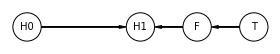

In [65]:
import daft

from causalgraphicalmodels import CausalGraphicalModel

plant_dag = CausalGraphicalModel(
    nodes=["H0", "H1", "F", "T"], edges=[("H0", "H1"), ("F", "H1"), ("T", "F")]
)
pgm = daft.PGM()
coordinates = {"H0": (0, 0), "T": (4, 0), "F": (3, 0), "H1": (2, 0)}
for node in plant_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in plant_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render(backgo)
plt.gca().invert_yaxis()

# Collider bias

In [69]:
# This one just copy pasting from pymc port
def inv_logit(x):
    return np.exp(x) / (1 + np.exp(x))


def sim_happiness(N_years=100, seed=1234):
    np.random.seed(seed)

    popn = pd.DataFrame(np.zeros((20 * 65, 3)), columns=["age", "happiness", "married"])
    popn.loc[:, "age"] = np.repeat(np.arange(65), 20)
    popn.loc[:, "happiness"] = np.repeat(np.linspace(-2, 2, 20), 65)
    popn.loc[:, "married"] = np.array(popn.loc[:, "married"].values, dtype="bool")

    for i in range(N_years):
        # age population
        popn.loc[:, "age"] += 1
        # replace old folk with new folk
        ind = popn.age == 65
        popn.loc[ind, "age"] = 0
        popn.loc[ind, "married"] = False
        popn.loc[ind, "happiness"] = np.linspace(-2, 2, 20)

        # do the work
        elligible = (popn.married == 0) & (popn.age >= 18)
        marry = np.random.binomial(1, inv_logit(popn.loc[elligible, "happiness"] - 4)) == 1
        popn.loc[elligible, "married"] = marry

    popn.sort_values("age", inplace=True, ignore_index=True)

    return popn

In [68]:
popn = sim_happiness()


In [71]:
popn.head()

,age,happiness,married
0,0,0.947368,False
1,0,2.000000,False
2,0,1.789474,False
3,0,1.578947,False
4,0,1.368421,False


In [79]:
popn = popn[popn.age > 17]
popn['age'] = popn.age - 18 / (65-18)

/var/folders/hy/9qct0wrx5pl34rzz153ys6sw0000gp/T/ipykernel_9512/1174518190.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  popn['age'] = popn.age - 18 / (65-18)


In [84]:
popn['marriage_indicator'] = popn.married.apply(lambda x: 1 if x else 0)
with pm.Model() as m7:
    sigma = pm.Exponential('sigma', 1)
    beta_age = pm.Normal('beta_age', 0, 2)
    alpha = np.array([pm.Normal('alpha_single', 0, 1), pm.Normal('alpha_married', 0, 1)])
    alpha = pm.Deterministic("alpha", alpha[0] * (1-popn.marriage_indicator) + alpha[1] * popn.marriage_indicator)
    mu = pm.Deterministic('mu', alpha + beta_age * popn['age'])
    sdr = pm.Normal('happiness', mu=mu , sigma=sigma, observed=popn['happiness'])
    m7_trace = pm.sample(return_inferencedata=True)

/var/folders/hy/9qct0wrx5pl34rzz153ys6sw0000gp/T/ipykernel_9512/2888753241.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  popn['marriage_indicator'] = popn.married.apply(lambda x: 1 if x else 0)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_married, alpha_single, beta_age, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


In [85]:
az.summary(m7_trace, var_names = ['alpha_single', 'alpha_married', 'beta_age'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_single,0.065,0.102,-0.147,0.243,0.003,0.002,1505.0,1795.0,1.0
alpha_married,1.479,0.127,1.227,1.708,0.003,0.002,1545.0,1827.0,1.0
beta_age,-0.015,0.003,-0.020,-0.010,0.000,0.000,1442.0,1709.0,1.0


In [86]:
popn['marriage_indicator'] = popn.married.apply(lambda x: 1 if x else 0)
with pm.Model() as m8:
    sigma = pm.Exponential('sigma', 1)
    beta_age = pm.Normal('beta_age', 0, 2)
    alpha = pm.Normal('alpha', 0, 1)
    mu = pm.Deterministic('mu', alpha + beta_age * popn['age'])
    sdr = pm.Normal('happiness', mu=mu , sigma=sigma, observed=popn['happiness'])
    m8_trace = pm.sample(return_inferencedata=True)

/var/folders/hy/9qct0wrx5pl34rzz153ys6sw0000gp/T/ipykernel_9512/3458000315.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  popn['marriage_indicator'] = popn.married.apply(lambda x: 1 if x else 0)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_age, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.8867005657326522, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8987936880096942, but should be close to 0.8. Try to increase the number of tuning steps.


In [87]:
az.summary(m8_trace, var_names = ['alpha', 'beta_age'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.006,0.125,-0.218,0.253,0.003,0.003,1590.0,1723.0,1.0
beta_age,-0.000,0.003,-0.006,0.005,0.000,0.000,1529.0,1732.0,1.0


In [89]:
n=200
g_on_p =1
g_on_c = 0
p_on_c = 2
u_on_p = 2
u_on_c = 2
u = 2 * np.random.binomial(n=1,p=0.5, size=n) - 1 
g = np.random.normal(size=n)
p = np.random.normal(g_on_p * g + u_on_p * u)
c = np.random.normal(g_on_c * g + u_on_c * u)
triads = pd.DataFrame({'uobserved':u, 'granparents':g, 'parents':p, 'childrens':c})



In [91]:
triads.head()

,uobserved,granparents,parents,childrens
0,1,-0.432948,2.194821,1.446184
1,-1,-0.000371,-1.662014,-2.697246
2,1,1.077268,2.517555,2.079002
3,-1,-1.247351,-3.055249,-2.345441
4,1,1.739514,1.402570,1.153817


Since there's influence of G on C through P, we control on P

In [95]:
popn['marriage_indicator'] = popn.married.apply(lambda x: 1 if x else 0)
with pm.Model() as m9:
    sigma = pm.Exponential('sigma', 1)
    beta_parent = pm.Normal('beta_parent', 0, 1)
    beta_grandparent = pm.Normal('beta_grandparent', 0, 1)
    alpha = pm.Normal('alpha', 0, 1)
    mu = pm.Deterministic('mu', alpha + beta_parent * triads['parents'] + beta_grandparent * triads['granparents'])
    sdr = pm.Normal('educational_achievement', mu=mu , sigma=sigma, observed=triads['childrens'])
    m9_trace = pm.sample(return_inferencedata=True)

/var/folders/hy/9qct0wrx5pl34rzz153ys6sw0000gp/T/ipykernel_9512/1542437129.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  popn['marriage_indicator'] = popn.married.apply(lambda x: 1 if x else 0)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_grandparent, beta_parent, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [96]:
az.summary(m9_trace, var_names=['beta_parent','beta_grandparent','alpha','sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_parent,0.824,0.044,0.747,0.915,0.001,0.000,4643.0,3276.0,1.0
beta_grandparent,-0.656,0.111,-0.858,-0.443,0.002,0.001,3933.0,3153.0,1.0
alpha,-0.000,0.101,-0.191,0.188,0.001,0.002,6852.0,3479.0,1.0
sigma,1.403,0.072,1.271,1.536,0.001,0.001,4684.0,2804.0,1.0


In [98]:
popn['marriage_indicator'] = popn.married.apply(lambda x: 1 if x else 0)
with pm.Model() as m10:
    sigma = pm.Exponential('sigma', 1)
    beta_parent = pm.Normal('beta_parent', 0, 1)
    beta_grandparent = pm.Normal('beta_grandparent', 0, 1)
    beta_u = pm.Normal('beta_u', 0, 1)
    alpha = pm.Normal('alpha', 0, 1)
    mu = pm.Deterministic('mu', alpha + beta_parent * triads['parents'] + beta_grandparent * triads['granparents']+ beta_u * triads['uobserved'])
    sdr = pm.Normal('educational_achievement', mu=mu , sigma=sigma, observed=triads['childrens'])
    m9_trace = pm.sample(return_inferencedata=True)

/var/folders/hy/9qct0wrx5pl34rzz153ys6sw0000gp/T/ipykernel_9512/2136256069.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  popn['marriage_indicator'] = popn.married.apply(lambda x: 1 if x else 0)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_u, beta_grandparent, beta_parent, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [99]:
az.summary(m9_trace, var_names=['beta_parent','beta_grandparent', 'beta_u', 'alpha','sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_parent,0.095,0.081,-0.060,0.247,0.002,0.001,1561.0,1973.0,1.0
beta_grandparent,-0.015,0.109,-0.211,0.194,0.002,0.002,1969.0,1938.0,1.0
beta_u,1.839,0.184,1.490,2.174,0.005,0.003,1642.0,2152.0,1.0
alpha,0.027,0.081,-0.123,0.174,0.001,0.001,4112.0,2300.0,1.0
sigma,1.130,0.056,1.026,1.234,0.001,0.001,3601.0,2653.0,1.0
